## Which gene is essential?

One can divide yeast genes as essential and non-essential. If any signle essential gene is removed, yeast cells are not viable. Below, I am going to see if there are any features of essential and non-essential genes and if we can predict if a gene is essential using classification models. Text files containing essential and non-essential genes were downloaded from https://www.yeastgenome.org/

In [2]:
# importing modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat

In [3]:
# importing data from all_genes_df_converted.csv

all_genes_df = pd.read_csv('all_genes_df_converted.csv')
all_genes_df.head()

,gene_ID,chromosome,gene_length[bp],A_content[%],T_content[%],C_content[%],G_content[%],GC_content[%],category
0,YAL001C,1,3573,35.32046,27.59586,15.81304,21.27064,37.08368,GC content below \nlength above
1,YAL002W,1,3825,31.89542,30.92810,18.74510,18.43137,37.17647,GC content below \nlength above
2,YAL003W,1,987,29.68592,31.10436,18.84498,20.36474,39.20972,GC content below \nlength below
3,YAL005C,1,1929,29.13427,26.80145,21.15086,22.91343,44.06429,GC content above \nlength above
4,YAL007C,1,648,30.86420,32.09877,17.59259,19.44444,37.03703,GC content below \nlength below


Data with essential and non essential genes are stored in txt files. I want to extract genes IDs and store them in respective lists.

In [4]:
# creating lists of essential and non essential genes form txt files

essential_genes = []
with open('essential_genes.txt', ) as file:
    for line in file:
        line_index_0 = line.split('\t')[0] # extraction of gene ID using split method
        if line_index_0[0] == 'Y': # every gene ID starts from Y and here we make sure we will not have other elements in the list
            essential_genes.append(line_index_0)

            
nonessential_genes = []
with open('non_essential_genes.txt', encoding="utf8") as file:
    for line in file:
        line_index_0 = line.split('\t')[0]
        if line_index_0[0] == 'Y':
            nonessential_genes.append(line_index_0)

Let's take a quick look on the created lists and if there are any genes that are in both (which shouldn't happen)

In [5]:
len(essential_genes)

1184

In [6]:
len(nonessential_genes)

4870

In [7]:
ambiguous_genes = set(essential_genes) & set(nonessential_genes)
len(ambiguous_genes)

111

Seems that there are 111 genes which are in both lists. Not too many but still, they should be removed from further analysis. I drop rowes from all_genes_df which have gene IDs that are in ambiguous_genes set.

In [8]:
rows_to_drop = all_genes_df[all_genes_df['gene_ID'].isin(ambiguous_genes)]
len(rows_to_drop)

109

In [9]:
print(len(all_genes_df))
all_genes_df.drop(rows_to_drop.index, inplace=True)
print(len(all_genes_df))

5894
5785


Dropping successfull. Turned out that among 111 genes in ambiguous_genes set, 2 were not in the all_genes_df. Now, let's label genes in all_genes_df as essential or non-essential.

In [10]:
essential = all_genes_df['gene_ID'].isin(essential_genes)
nonessential = all_genes_df['gene_ID'].isin(nonessential_genes)
condition_list = [essential, nonessential]
categories = ['yes', 'no']
all_genes_df['is_essential'] = np.select(condition_list, categories, default='unknown')

In [11]:
all_genes_df['is_essential'].value_counts()

no         4310
yes        1007
unknown     468
Name: is_essential, dtype: int64

468 genes are labeles as unknown. Should be removed.

In [12]:
unknow_rows_to_drop = all_genes_df[all_genes_df['is_essential'] == 'unknown']
print(len(unknow_rows_to_drop))

print(len(all_genes_df))
all_genes_df.drop(unknow_rows_to_drop.index, inplace=True)
print(len(all_genes_df))

468
5785
5317


Before building clasification model, let's take a look if there are any obvious pattern in essential and non-essential genes distributions.

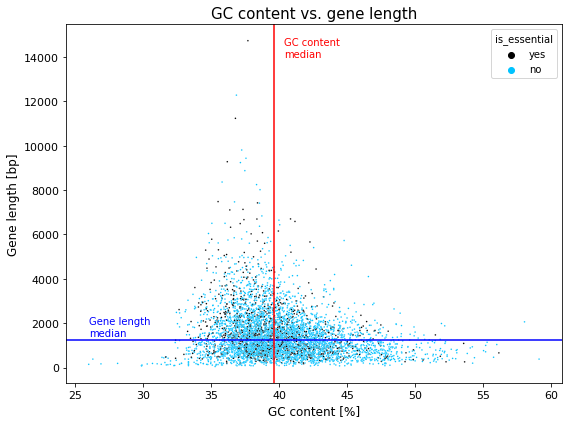

In [13]:
# defining medians for GC content and gene length
GC_median = all_genes_df['GC_content[%]'].median()
length_median = all_genes_df['gene_length[bp]'].median()

fig, ax = plt.subplots()
fig.set_size_inches([8,6])

ax = sns.scatterplot(data=all_genes_df, x="GC_content[%]", y='gene_length[bp]', s=2.5, hue='is_essential', palette=['#000000', '#00C3FF'])

ax.set_title('GC content vs. gene length', fontsize=15)
ax.set_xlabel('GC content [%]', fontsize=12)
ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=11)
ax.set_ylabel('Gene length [bp]', fontsize=12)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=11)


ax.axhline(length_median, c='b')
ax.text(26, length_median + 200, 'Gene length \nmedian', c='b', fontsize=10)
ax.axvline(GC_median, c='r')
ax.text(GC_median + 0.75, 14000, 'GC content \nmedian', c='r', fontsize=10)
plt.tight_layout()
plt.show()

No obvious pattern is visible. Let's also see charts with both groups separately. % content of genes in each quarter will also be given.

In [14]:
# calculating % of each category for essential and non-essential genes
essential = all_genes_df[all_genes_df['is_essential']=='yes']
nonessential = all_genes_df[all_genes_df['is_essential']=='no']

categories_essential = round(essential['category'].value_counts(normalize=True).sort_index(ascending=False) * 100, 2)
categories_nonessential = round(nonessential['category'].value_counts(normalize=True).sort_index(ascending=False) * 100, 2)

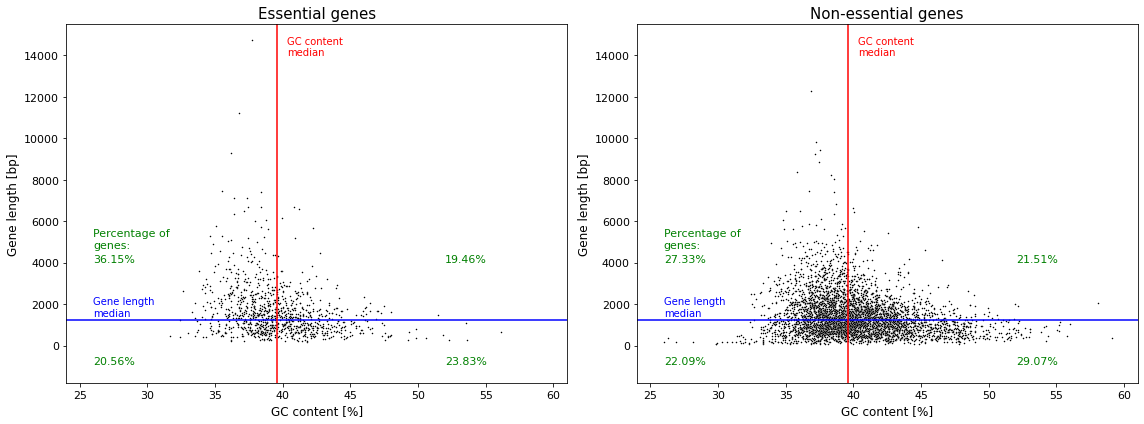

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches([16,6])

plt.subplot(121)
ax = sns.scatterplot(data=essential, x="GC_content[%]", y='gene_length[bp]', s=2.5, color='black')

ax.set_title('Essential genes', fontsize=15)
ax.set_xlim(24,61)
ax.set_xlabel('GC content [%]', fontsize=12)
ax.set_xticklabels(ax.get_xticks().astype(int), fontsize=11)

ax.set_ylabel('Gene length [bp]', fontsize=12)
ax.set_ylim(-1800, 15500)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=11)


ax.text(26, 4700, s='Percentage of \ngenes:', c='g', fontsize=11)
ax.text(26, -900, s=(str(categories_essential['GC content below \nlength below'])+ '%'), c='g', fontsize=11)
ax.text(26, 4000, s=(str(categories_essential['GC content below \nlength above'])+ '%'), c='g', fontsize=11)
ax.text(52, -900, s=(str(categories_essential['GC content above \nlength below'])+ '%'), c='g', fontsize=11)
ax.text(52, 4000, s=(str(categories_essential['GC content above \nlength above'])+ '%'), c='g', fontsize=11)

ax.axhline(length_median, c='b')
ax.text(26, length_median + 200, 'Gene length \nmedian', c='b', fontsize=10)
ax.axvline(GC_median, c='r')
ax.text(GC_median + 0.75, 14000, 'GC content \nmedian', c='r', fontsize=10)

plt.subplot(122)

ax2 = sns.scatterplot(data=nonessential, x="GC_content[%]", y='gene_length[bp]', s=2.5, color='black')

ax2.set_title('Non-essential genes', fontsize=15)
ax2.set_xlabel('GC content [%]', fontsize=12)
ax2.set_xlim(ax.get_xlim())
ax2.set_xticklabels(ax.get_xticks().astype(int), fontsize=11)

ax2.set_ylabel('Gene length [bp]', fontsize=12)
ax2.set_ylim(ax.get_ylim())
ax2.set_yticklabels(ax.get_yticks().astype(int), fontsize=11)

ax2.text(26, 4700, s='Percentage of \ngenes:', c='g', fontsize=11)
ax2.text(26, -900, s=(str(categories_nonessential['GC content below \nlength below'])+ '%'), c='g', fontsize=11)
ax2.text(26, 4000, s=(str(categories_nonessential['GC content below \nlength above'])+ '%'), c='g', fontsize=11)
ax2.text(52, -900, s=(str(categories_nonessential['GC content above \nlength below'])+ '%'), c='g', fontsize=11)
ax2.text(52, 4000, s=(str(categories_nonessential['GC content above \nlength above'])+ '%'), c='g', fontsize=11)

ax2.axhline(length_median, c='b')
ax2.text(26, length_median + 200, 'Gene length \nmedian', c='b', fontsize=10)
ax2.axvline(GC_median, c='r')
ax2.text(GC_median + 0.75, 14000, 'GC content \nmedian', c='r', fontsize=10)

plt.tight_layout()
plt.show()

That looks interesting. 36,15% of essential genes are in GC content below \ length above category, which is 7,71 percentage points more than it is for all genes. Non-essential genes differ around 1 percentage point comparing with all genes. Let's see if this differences are statistically significant using chi-squared test

In [16]:
essential = all_genes_df[all_genes_df['is_essential'] == 'yes']['category'].value_counts().sort_index()
nonessential = all_genes_df[all_genes_df['is_essential'] == 'no']['category'].value_counts().sort_index()


chi2 = stat.chi2_contingency([essential, nonessential])
print(chi2)
print('p-value =', chi2[1])

(32.3442491178899, 4.428205122671789e-07, 3, array([[ 212.68779387,  282.76302426,  292.04325748,  219.50592439],
       [ 910.31220613, 1210.23697574, 1249.95674252,  939.49407561]]))
p-value = 4.428205122671789e-07


Very low p-value shows that there is a significant difference in distributions between essential and non-essential genes

## Building classification models

The fact that essential genes do not form a clear cluster indicates that classification models will be useless. But let's give it a try.

In [17]:
# importing modules

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, make_scorer

In [18]:
# preparing y and X datasets

mapper = {'yes' : True, 'no' : False} # preparing mapper for assigning boolean data type instead of yes/no in 'is_essental' column
y = all_genes_df['is_essential'].map(mapper)
X = all_genes_df.drop(['is_essential', 'gene_ID', 'category', 'GC_content[%]'], axis=1)

Model building road map:

- Essential genes are not a separate cluster, therefore distinguishing them from non-essential genes by support vector machine or logistic regression seems a poor choice. However, as we see in the previos charts, there are areas in which essential genes appear more often. This gives some hopes for k-nearest neighbors algorithm, which classify records based on neighboring samples. This algorithm will be used then.

- I would like to see how model performs for various k-neighbors. For that, I create outer loop which will test every indicated k-neighbor.

- optmal distance metric (euclidean or manhattan) as well as model evaluation will be done by nested cross-validation. GridSearchCV (distance metric parameter tuning) and cross_validate (model evaluation) functions will be used for nested cross-validation. I would like also to see how many times a particurlar distance metric will be choosen during each round of GridSearch cross-validation.

- for distance metric selection, recall will be used as evaluation metric. Recall (sensitivity) tells how good is the model in detectng positive class (in our case - essential genes) in a dataset, which is crucial feature in this task - we want to detects as many essential genes as possible. Therefore, recall seems the most important evaluation metric is this aspect.

- for evaluation on the test set, I will again use recall. However, there is a risk that our model will aim to label as many genes as possible as essential. In this case we will have a high recall since there will be only few false negatives. However, at the same time, there could be many false positives, because many non-essential genes will be labeles as essential. To control if model is not biased in this manner, I would like to see in model evaluation also recall of a negative class (specificity), which will tell us how good is the model in finding negative classes.

- since there is no default metric allowing us to see  recall of a negative class (specificity), I create the recall_neg_class function which will extract required data for calculating recall of a negative class from confusion matrix.

In [19]:
# defining recall_neg_class function
# function is based on a solution proposed by sedeh (https://stackoverflow.com/questions/33275461/specificity-in-scikit-learn)

def recall_neg_class(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    value = tn / (tn + fp)
    return value

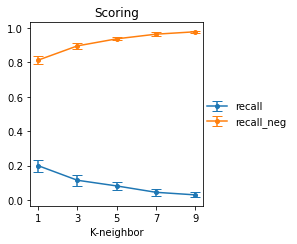

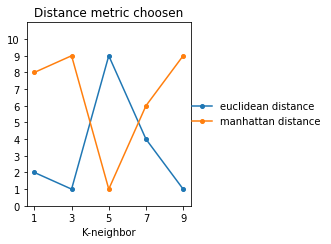

In [27]:
# defining k-neighbors for model tuning
neighbors = list(range(1,10,2))

# creating lists storing metrics scores and selected distance metric during each GridSearchCV round.
recall_mean_list = []
recall_std_list = []

recall_neg_means_list = []
recall_neg_std_list = []

euclidean_distance = []
manhattan_distance = []


# outer loop iterating over choosen k-neighbors
for k in neighbors:

    clf = KNeighborsClassifier(n_neighbors = k)

    # selecting parameters for model tuning
    param = {'metric' : ['euclidean', 'manhattan']}
    best_param = []
    
    # preparing scoring metrics for model evaluation
    scoring = {'recall' : make_scorer(recall_score), \
               'recall_neg': make_scorer(recall_neg_class)}

    # performing nested cross-validation. recall score for model tuning. recall and recall_neg for (scroring dictionary) for model evaluation
    cv_inner = 10
    cv_outer = 10

    best_model = GridSearchCV(clf, param, cv=cv_inner, scoring='recall')
    scores = cross_validate(best_model, X, y, cv=cv_outer, scoring=scoring, return_estimator=True)

    # calculating means and standard deviations of each metric scores from splits done by cross_validate()
    recall_mean = round((scores['test_recall']).mean(), 3)
    recall_mean_list.append(recall_mean)
    
    recall_std = round((scores['test_recall']).std(), 3)
    recall_std_list.append(recall_std)

    recall_neg_mean = round((scores['test_recall_neg']).mean(), 3)
    recall_neg_means_list.append(recall_neg_mean)
    
    recall_neg_std = round((scores['test_recall_neg']).std(), 3)
    recall_neg_std_list.append(recall_neg_std)

    # extracting information how many times each metric was used during each GridSearchCV round.
    for i in range(cv_outer):
        best_param.append(scores['estimator'][i].best_params_['metric'])
        
    euclidean_distance.append(best_param.count('euclidean'))
    manhattan_distance.append(best_param.count('manhattan'))


# plotting scores of recall and recall_neg scores for each k-neighbor
plt.figure(figsize = [4.5, 3.5])
plt.errorbar(neighbors, recall_mean_list, yerr=recall_std_list, capsize=5, marker='o', markersize=4, label='recall')
plt.errorbar(neighbors, recall_neg_means_list, yerr=recall_neg_std_list, capsize=5, marker='o', markersize=4, label='recall_neg')
plt.title('Scoring')
plt.xticks(neighbors)
plt.xlabel('K-neighbor')
plt.legend(frameon=False, loc=10, bbox_to_anchor=(1.25,0.5), fontsize=10)
plt.tight_layout()
plt.show()


# plotting best distance metric during each each GridSearchCV round.
plt.figure(figsize = [5.5, 3.5])
plt.plot(neighbors, euclidean_distance, marker='o', markersize=4, label='euclidean distance')
plt.plot(neighbors, manhattan_distance, marker='o', markersize=4, label='manhattan distance')
plt.title('Distance metric choosen')
plt.xticks(neighbors)
plt.xlabel('K-neighbor')
plt.ylim(0,11)
plt.yticks(range(0,11,1))
plt.legend(frameon=False, loc=10, bbox_to_anchor=(1.4,0.5), fontsize=10)
plt.tight_layout()
plt.show()



Model evaluation, as expected, is not encouraging. The highest recall was 0.2 for k-neighbor = 1, which means that we were able to detect only 20% of all essential genes. The more neighbors in the algorithm, the recall was lower. Moreover, the recall of negative class is inversly correlated with recall. That indicates that the model acts randomly instead of recognizing essential and non-essential genes.

For most of the degrees, manhattan distance metric was choosen in most of the cases during GridSearch cross-validation rounds, except for the K = 5, where euclidean distance was prefered.

Since k-nearest neighbor algorithm was not successful, let's give it a try to random forest classifier. Performance with different number of trees in the forest will be evaluated using recall and recall of negative class metrics.

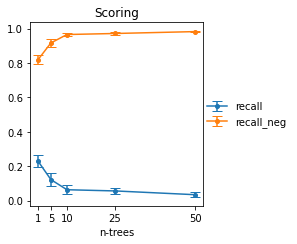

In [29]:

# number of trees to test
trees = [1,5,10,25,50]

# lists storing evaluation results
recall_mean_list = []
recall_std_list = []

recall_neg_means_list = []
recall_neg_std_list = []



for n in trees:

    clf = RandomForestClassifier(n_estimators = n)

    # selecting parameters for model tuning

    scoring = {'recall' : make_scorer(recall_score), \
               'recall_neg': make_scorer(recall_neg_class)}
    
    # corss-validation of the model
    scores = cross_validate(clf, X, y, cv=10, scoring=scoring, return_estimator=True)

    # calculating means and standard deviations of each metric scores from splits done by cross_validate()
    
    recall_mean = round((scores['test_recall']).mean(), 3)
    recall_mean_list.append(recall_mean)
    
    recall_std = round((scores['test_recall']).std(), 3)
    recall_std_list.append(recall_std)

    recall_neg_mean = round((scores['test_recall_neg']).mean(), 3)
    recall_neg_means_list.append(recall_neg_mean)
    
    recall_neg_std = round((scores['test_recall_neg']).std(), 3)
    recall_neg_std_list.append(recall_neg_std)


plt.figure(figsize = [4.5, 3.5])
plt.errorbar(trees, recall_mean_list, yerr=recall_std_list, capsize=5, marker='o', markersize=4, label='recall')
plt.errorbar(trees, recall_neg_means_list, yerr=recall_neg_std_list, capsize=5, marker='o', markersize=4, label='recall_neg')
plt.title('Scoring')
plt.xticks(trees)
plt.xlabel('n-trees')
plt.legend(frameon=False, loc=10, bbox_to_anchor=(1.25,0.5), fontsize=10)
plt.tight_layout()
plt.show()



Similarly as for the k-nearest neighbor algorithm - recall and negative class recall are inversly correlated. This suggest random acting of the model instead of recognizing essential and non-essential genes